# Create Input Data

This script takes a variety of chemical identifiers for both insecticidal and non-insecticidal compounds, cleans these chemicals, converts them to SMILES, and then converts SMILES to graphs.

Written by Tobias D. Muellers

## Load Dependencies

In [1]:
import pandas as pd
import numpy as np

In [1]:
import requests
from bs4 import BeautifulSoup as bs
import time
from selenium import webdriver
import cirpy
from tqdm import tqdm
import urllib.request
from urllib.error import HTTPError
from urllib.request import urlopen
import rdkit

# Scrape Databases for Chemicals

In [27]:
from selenium.webdriver.chrome.options import Options
options = Options()
options.add_argument("--headless")
driver = webdriver.Chrome(options=options)

In [28]:
# function to get content from https://www.pesticideinfo.org/
# based on https://realpython.com/beautiful-soup-web-scraper-python/
def pesticideinfo_get(PRI_start, PRI_end):
    """
    this function takes starting and ending ids for this database and constructs a range.
    Based on the range of PRIs, it extracts data from each PesticideInfo page. 
    PRI_start = integer
    PRI_end = integer
    """
    # webdriver workaround from https://stackoverflow.com/questions/76928765/attributeerror-str-object-has-no-attribute-capabilities-in-selenium
    cservice = webdriver.ChromeService(
        executable_path="C:/Users/tobia/OneDrive/Documents/GitHub/BugBuster/chromedriver-win64/chromedriver-win64/chromedriver.exe",
        chrome_options=options)
    driver = webdriver.Chrome(service = cservice)
    # driver code based on https://stackoverflow.com/questions/52687372/beautifulsoup-not-returning-complete-html-of-the-page
    
    # make range
    PRIs = np.arange(PRI_start, PRI_end, 1)

    # set up storage for a dataframe
    pris = []
    names = []
    casrns = []
    classes = []
    mws = []
    uses =[]

    for pri in PRIs:
        URL = "https://www.pesticideinfo.org/chemical/PRI"+str(pri)
        driver.get(URL)
        time.sleep(0.25) # wait for page to load
        page = driver.page_source
        soup = bs(page, "html.parser") # parse page
        table = soup.find_all("div", {"class": "data-table-key-value"}) #get values from table of interest
        
        if len(table) < 5:
            print(f'{pri} does not exist')
        else:
            # now extract desired information 
            pris.append(pri)
            name = str(table[0]).split('</div>')[1][5:]
            names.append(name)
            casrn = str(table[2]).split('</div>')[1][5:]
            casrns.append(casrn)
            chem_class = str(table[4]).split('</div>')[1][5:]
            classes.append(chem_class)
            mw = str(table[5]).split('</div>')[1][5:]
            mws.append(mw)
            use = str(table[6]).split('</div>')[1][5:]
            uses.append(use)

    data = {'name': names, 'pri': pris, 'casrn': casrns, 
            'class': classes, 'mw': mws, 'use': uses}
    df = pd.DataFrame(data)
    
    driver.quit()
    
    return df

In [29]:
#extracted_1_10001 = pesticideinfo_get(1, 10001)
#extracted_10001_20001 = pesticideinfo_get(10001, 20001)
#extracted_20001_30001 = pesticideinfo_get(20001, 30001)
#extracted_30001_50001 = pesticideinfo_get(30001, 50001)
extracted_50001_100001 = pesticideinfo_get(50001, 100001)

50001 does not exist
50002 does not exist
50003 does not exist
50004 does not exist
50005 does not exist
50006 does not exist
50007 does not exist
50008 does not exist
50009 does not exist
50010 does not exist
50011 does not exist
50012 does not exist
50013 does not exist
50014 does not exist
50015 does not exist
50016 does not exist
50017 does not exist
50018 does not exist
50019 does not exist
50020 does not exist
50021 does not exist
50022 does not exist
50023 does not exist
50024 does not exist
50025 does not exist
50026 does not exist
50027 does not exist
50028 does not exist
50029 does not exist
50031 does not exist
50032 does not exist
50033 does not exist
50034 does not exist
50035 does not exist
50036 does not exist
50037 does not exist
50038 does not exist
50039 does not exist
50040 does not exist
50041 does not exist
50042 does not exist
50043 does not exist
50044 does not exist
50045 does not exist
50046 does not exist
50047 does not exist
50048 does not exist
50049 does no

In [30]:
extracted_50001_100001.tail()
extracted_50001_100001.shape
extracted_50001_100001.to_csv("pest_info_db_50001_100001.csv")

# Get SMILES

In [6]:
# load extracted data
raw_pestinfo_1_10001 = pd.read_csv('pest_info_db_1_10001.csv')
print(raw_pestinfo_1_10001.shape)
raw_pestinfo_10001_20001 = pd.read_csv('pest_info_db_10001_20001.csv')
print(raw_pestinfo_10001_20001.shape)
raw_pestinfo_20001_30001 = pd.read_csv('pest_info_db_20001_30001.csv')
print(raw_pestinfo_20001_30001.shape)
raw_pestinfo_30001_50001 = pd.read_csv('pest_info_db_30001_50001.csv')
print(raw_pestinfo_30001_50001.shape)
raw_pestinfo = pd.concat([raw_pestinfo_1_10001, raw_pestinfo_10001_20001, raw_pestinfo_20001_30001, raw_pestinfo_30001_50001])
print(raw_pestinfo.shape)
raw_pestinfo.tail(1)

(6261, 7)
(339, 7)
(1726, 7)
(6901, 7)
(15227, 7)


,Unnamed: 0,name,pri,casrn,class,mw,use
6900,6900,NaN,49591,NaN,Not Listed,Not Listed,NaN


In [7]:
# drop where name is NaN
pestinfo_drop = raw_pestinfo[pd.isnull(raw_pestinfo['name'])]
pestinfo_keep = raw_pestinfo[pd.isnull(raw_pestinfo['name']) == False]
print(pestinfo_drop.shape)
print(pestinfo_keep.shape)

(194, 7)
(15033, 7)


In [9]:
# add smiles based on casrn
# use cirpy 
# add cactus as needed
def add_smiles(df, cas_col, name_col):
    temp_df = df.copy() # avoid overwrite
    casrns = temp_df[cas_col]
    names = temp_df[name_col]
    smiles_cirpy_cas_storage = []
    smiles_cirpy_name_storage = []

    for cas in tqdm(casrns):
        if cas == "Not Listed":
            smiles_cirpy_casrn = float('NaN')
        else:
            smiles_cirpy_casrn = cirpy.resolve(cas, 'smiles')
        smiles_cirpy_cas_storage.append(smiles_cirpy_casrn)

    for name in tqdm(names):
        smiles_cirpy_name = cirpy.resolve(name, 'smiles')
        smiles_cirpy_name_storage.append(smiles_cirpy_name)

    temp_df['smiles_cirpy_casrn'] = smiles_cirpy_cas_storage
    temp_df['smiles_cirpy_name'] = smiles_cirpy_name_storage

    return temp_df

In [14]:
# only take pesticides
pesticides = pestinfo_keep[pestinfo_keep['use'].str.contains('|'.join(['Insecticide','Fungicide','Microbiocide',
                                                             'Herbicide','Algaecide','Nematicide','Rodenticide',
                                                            'Molluscicide','Avicide', 'Piscicide']))]
print(pesticides.shape)
pesticides.tail(5)

(3827, 7)


,Unnamed: 0,name,pri,casrn,class,mw,use
6750,6750,"Wolbachia pipientis, wAlbB Strain, intracellul...",38816,Not Listed,Microbial,0,Insecticide
6754,6754,Sterile grain inoculated with Muscodor albus s...,38820,Not Listed,Microbial,0,Fungicide
6755,6755,Alternaria tenuissima activation protein,38824,Not Listed,Microbial,0,Herbicide
6762,6762,BHC epislon,38831,6108-10-7,Organochlorine,0,Insecticide
6763,6763,Pyrapropoyne,38833,1803108-03-3,Pyrazole,0,Fungicide


In [15]:
pestinfo_pesticide_smiles = add_smiles(pesticides, 'casrn', 'name')

100%|██████████| 3827/3827 [31:38<00:00,  2.02it/s]


In [16]:
# save intermediate output
pestinfo_pesticide_smiles.to_csv("pestinfodb_pesticide_smiles.csv")

## Trim SMILES

In [82]:
# load smiles
smiles_pestinfo = pd.read_csv('pestinfodb_pesticide_smiles.csv')
print(smiles_pestinfo.shape)

(3827, 10)


In [83]:
smiles_pestinfo.head()

,Unnamed: 0.1,Unnamed: 0,name,pri,casrn,class,mw,use,smiles_cirpy_casrn,smiles_cirpy_name
0,1,1,"1-(4-phenyl phenoxy)-1-(1,2,4-triazole-1)-3,3-...",11,Not Listed,Azole,0.0,Fungicide,NaN,NaN
1,5,5,1-(alkyl-amino)-3-aminopropane hydrochloride,15,Not Listed,Alkyl Amino Propane,0.0,Microbiocide,NaN,NaN
2,6,6,"1-(Alkyl* amino)-3-aminopropane *(47%C12, 18%C...",16,61791-67-1,Alkyl Amino Propane,0.0,Microbiocide,NaN,NaN
3,7,7,1-(Alkyl* amino)-3-aminopropane *(as in fatty ...,17,61791-63-7,Alkyl Amino Propane,0.0,Microbiocide,NaN,NaN
4,8,8,1-(Alkyl* amino)-3-aminopropane diacetate *(37...,18,68911-78-4,Alkyl Amino Propane,0.0,Microbiocide,NaN,NaN


In [84]:
# remove no smiles
def merge_and_remove_smiles(df, cirpy_casrn_smiles, cirpy_name_smiles):
    temp = df.copy()
    idx = range(0, temp.shape[0])
    cirpy_casrn_smiles = temp[cirpy_casrn_smiles]
    cirpy_name_smiles = temp[cirpy_name_smiles]

    smiles_storage = []
    for i in idx:
        if pd.isnull(cirpy_casrn_smiles[i]) == False:
            smiles = cirpy_casrn_smiles[i]
        else:
            if pd.isnull(cirpy_name_smiles[i]) == False:
                smiles = cirpy_name_smiles[i]
            else:
                smiles = float('NaN')
        smiles_storage.append(smiles)

    temp['smiles'] = smiles_storage
    
    return temp

In [85]:
smiles_pestinfo_cleaned = merge_and_remove_smiles(smiles_pestinfo, "smiles_cirpy_casrn", "smiles_cirpy_name")
print(smiles_pestinfo_cleaned.shape)

(3827, 11)


In [86]:
smiles_pestinfo_cleaned = smiles_pestinfo_cleaned.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'smiles_cirpy_casrn', 'smiles_cirpy_name'])
print(smiles_pestinfo_cleaned.shape)

(3827, 7)


In [87]:
smiles_pestinfo_cleaned = smiles_pestinfo_cleaned[pd.isnull(smiles_pestinfo_cleaned['smiles']) == False]
print(smiles_pestinfo_cleaned.shape)

(2290, 7)


In [26]:
print(smiles_pestinfo_cleaned.shape)
smiles_pestinfo_cleaned.head(5)

(2290, 7)


,name,pri,casrn,class,mw,use,smiles
14,"1-bromo-3-chloro-5,5-dimethyl hydantoin",40,16079-88-2,Hydantoin,241.47,"Fungicide,Herbicide,Microbiocide",CC1(C)N(Br)C(=O)N(Cl)C1=O
15,1-Chloro-2-nitrobenzene,46,88-73-3,Unclassified,157.56,Insecticide,[O-][N+](=O)c1ccccc1Cl
16,1-Chloro-3-nitrobenzene,49,121-73-3,Unclassified,157.56,Insecticide,[O-][N+](=O)c1cccc(Cl)c1
17,1-Chloro-4-nitrobenzene,50,100-00-5,Unclassified,157.56,"Chemical intermediate,Insecticide",[O-][N+](=O)c1ccc(Cl)cc1
18,1-Heptadecenyl-2-(2-hydroxyethyl)-2-imidazolin...,57,"68-41-2, 53466-82-3",Imidazoline,0.00,"Algaecide,Microbiocide",[Cl-].CCCCCCCCCCCCCCCC=C[NH+]1CCN=C1CCO


In [27]:
# drop unneeded columns
smiles_pestinfo_cleaned = smiles_pestinfo_cleaned.drop(columns=['pri','mw'])

# Add other pre-made datasets

In [28]:
# PESTICIDES|NORMAN: Natural Product Insecticides
# A list of naturally occurring insecticides curated and provided to the NORMAN Suspect List Exchange 
# (https://www.norman-network.com/nds/SLE/) by Reza Aalizadeh (University of Athens). DOI: https://doi.org/10.5281/zenodo.3544742
norman_insecticides = pd.read_csv('Chemical List NPINSECT-2025-04-03.csv')
print(norman_insecticides.shape)
norman_insecticides = norman_insecticides.drop(columns=['DTXSID', 'INCHIKEY','INCHI STRING',
                                                       'MOLECULAR FORMULA', 'AVERAGE MASS', 'MONOISOTOPIC MASS',
                                                       'QC Level', '# ToxCast Active', 'Total Assays', '% ToxCast Active'])

norman_insecticides['use'] = 'Insecticide'
norman_insecticides.head(1)

(84, 14)


,PREFERRED NAME,CASRN,IUPAC NAME,SMILES,use
0,3'-Methoxyrocaglamide,189322-69-8,"(1R,2R,3S,3aR,8bS)-3a-(3,4-Dimethoxyphenyl)-1,...",COC1=CC2=C(C(OC)=C1)[C@]1(O)[C@H](O)[C@@H]([C@...,Insecticide


In [29]:
# CATEGORY: Pyrethroids
# A pyrethroid is an organic compound similar to the natural pyrethrins produced by the flowers of pyrethrums 
# (Chrysanthemum cinerariaefolium and C. coccineum). 
# Pyrethroids constitute the majority of commercial household insecticides.
pyrethroid_insecticides = pd.read_csv('Chemical List PYRETHROIDS-2025-04-18.csv')
print(pyrethroid_insecticides.shape)
pyrethroid_insecticides = pyrethroid_insecticides.drop(columns=['DTXSID', 'INCHIKEY','INCHI STRING',
                                                       'MOLECULAR FORMULA', 'AVERAGE MASS', 'MONOISOTOPIC MASS',
                                                       'QC Level', '# ToxCast Active', 'Total Assays', '% ToxCast Active'])

pyrethroid_insecticides['use'] = 'Insecticide'
pyrethroid_insecticides.head(1)

(25, 14)


,PREFERRED NAME,CASRN,IUPAC NAME,SMILES,use
0,Flucythrinate,70124-77-5,Cyano(3-phenoxyphenyl)methyl 2-[4-(difluoromet...,CC(C)C(C(=O)OC(C#N)C1=CC=CC(OC2=CC=CC=C2)=C1)C...,Insecticide


In [31]:
# ECHA Active substances
# AC-Acarizide; AL-Algicide; BA-Bactericide; BI-Biocide; FU-Fungicide;
# HB-Herbicide; IN-Insekticide; MO-Molluscicide; MI-Miticide; NE-Nematicide; 
# PA-Plant activator; PG-Plant growth regulator; RE-Repellent; RO-Rodenticide; VI-Viricide
# also from https://doi.org/10.3390/agrochemicals2010008
ECHA_actives = pd.read_csv("ActiveSubstanceExport_16-04-2025.csv")
print(ECHA_actives.shape)
keep_ECHA_columns = ['Substance', 'CAS Number','Functions']
ECHA_actives = ECHA_actives[keep_ECHA_columns]
ECHA_actives = ECHA_actives.rename(columns={'Substance' : 'PREFERRED NAME', 'CAS Number':'CASRN','Functions':'use'})
# remove NaN
ECHA_actives = ECHA_actives.dropna(subset=['use'])
print(ECHA_actives.shape)
ECHA_actives['use'] = ECHA_actives['use'].replace('IN', 'Insecticide')
ECHA_actives['use'] = ECHA_actives['use'].replace('AC', 'Acarizide')
ECHA_actives['use'] = ECHA_actives['use'].replace('BA', 'Bactericide')
ECHA_actives['use'] = ECHA_actives['use'].replace('BI', 'Biocide')
ECHA_actives['use'] = ECHA_actives['use'].replace('FU', 'Fungicide')
ECHA_actives['use'] = ECHA_actives['use'].replace('HB', 'Herbicide')
ECHA_actives['use'] = ECHA_actives['use'].replace('MO', 'Molluscicide')
ECHA_actives['use'] = ECHA_actives['use'].replace('MI', 'Miticide')
ECHA_actives['use'] = ECHA_actives['use'].replace('NE', 'Nematicide')
ECHA_actives['use'] = ECHA_actives['use'].replace('RO', 'Rodenticide')
ECHA_actives['use'] = ECHA_actives['use'].replace('VI', 'Viricide')
# take only insecticides for now
ECHA_actives = ECHA_actives[ECHA_actives['use'].str.contains('|'.join(['Insecticide','Acarizide','Bactericide','Biocide',
                                                                      'Fungicide','Herbicide','Molluscicide','Miticide',
                                                                      'Nematicide','Rodenticide','Viricide']))]
print(ECHA_actives.shape)
ECHA_actives.head(5)

(1465, 33)
(946, 3)
(648, 3)


,PREFERRED NAME,CASRN,use
71,"2,4,5-T",93-76-5,Herbicide
77,2-(dithiocyanomethylthio)-benzothiazol,No CAS allocated,Fungicide
91,2-Phenylphenol (incl. sodium salt orthophenyl ...,90-43-7,Fungicide
99,3-phenyl-2-propenal (Cinnamaldehyde),104-55-2,Fungicide
103,4-t-Pentylphenol,80-46-6,Bactericide


In [49]:
# add smiles
#ECHA_active_smiles = add_smiles(ECHA_actives, 'CASRN', 'PREFERRED NAME')

In [68]:
print(ECHA_active_smiles.shape)
print(type(ECHA_active_smiles))
ECHA_active_smiles.reset_index().head()

(648, 5)
<class 'pandas.core.frame.DataFrame'>


,index,PREFERRED NAME,CASRN,use,smiles_cirpy_casrn,smiles_cirpy_name
0,71,"2,4,5-T",93-76-5,Herbicide,OC(=O)COc1cc(Cl)c(Cl)cc1Cl,OC(=O)COc1cc(Cl)c(Cl)cc1Cl
1,77,2-(dithiocyanomethylthio)-benzothiazol,No CAS allocated,Fungicide,None,N#CSC(SC#N)Sc1sc2ccccc2n1
2,91,2-Phenylphenol (incl. sodium salt orthophenyl ...,90-43-7,Fungicide,Oc1ccccc1c2ccccc2,None
3,99,3-phenyl-2-propenal (Cinnamaldehyde),104-55-2,Fungicide,O=C/C=C/c1ccccc1,O=CC=Cc1ccccc1.O=CC=Cc2ccccc2
4,103,4-t-Pentylphenol,80-46-6,Bactericide,CCC(C)(C)c1ccc(O)cc1,CCC(C)(C)c1ccc(O)cc1


In [69]:
ECHA_active_cleaned = merge_and_remove_smiles(ECHA_active_smiles.reset_index(), "smiles_cirpy_casrn", "smiles_cirpy_name")

In [71]:
ECHA_active_cleaned = ECHA_active_cleaned.drop(columns=['index', 'smiles_cirpy_casrn', 'smiles_cirpy_name'])

,PREFERRED NAME,CASRN,use,smiles
0,"2,4,5-T",93-76-5,Herbicide,OC(=O)COc1cc(Cl)c(Cl)cc1Cl
1,2-(dithiocyanomethylthio)-benzothiazol,No CAS allocated,Fungicide,N#CSC(SC#N)Sc1sc2ccccc2n1
2,2-Phenylphenol (incl. sodium salt orthophenyl ...,90-43-7,Fungicide,Oc1ccccc1c2ccccc2
3,3-phenyl-2-propenal (Cinnamaldehyde),104-55-2,Fungicide,O=C/C=C/c1ccccc1
4,4-t-Pentylphenol,80-46-6,Bactericide,CCC(C)(C)c1ccc(O)cc1


In [72]:
print(ECHA_active_cleaned.shape)
ECHA_active_cleaned = ECHA_active_cleaned[pd.isnull(ECHA_active_cleaned['smiles']) == False]
print(ECHA_active_cleaned.shape)

(648, 4)
(510, 4)


# Dataset Merge

In [99]:
print(pyrethroid_insecticides.shape)
merge_pyr = pyrethroid_insecticides.drop(columns=['IUPAC NAME'])
print(merge_pyr.shape)
merge_pyr.head(1)

(25, 5)
(25, 4)


,PREFERRED NAME,CASRN,SMILES,use
0,Flucythrinate,70124-77-5,CC(C)C(C(=O)OC(C#N)C1=CC=CC(OC2=CC=CC=C2)=C1)C...,Insecticide


In [100]:
print(norman_insecticides.shape)
merge_norm = norman_insecticides.drop(columns=['IUPAC NAME'])
print(merge_norm.shape)
merge_norm.head(1)

(84, 5)
(84, 4)


,PREFERRED NAME,CASRN,SMILES,use
0,3'-Methoxyrocaglamide,189322-69-8,COC1=CC2=C(C(OC)=C1)[C@]1(O)[C@H](O)[C@@H]([C@...,Insecticide


In [101]:
print(ECHA_active_cleaned.shape)
merge_echa = ECHA_active_cleaned.rename(columns={'smiles':'SMILES'})
merge_echa = merge_echa.iloc[:, [0,1,3,2]]
print(merge_echa.shape)
merge_echa.head(1)

(510, 4)
(510, 4)


,PREFERRED NAME,CASRN,SMILES,use
0,"2,4,5-T",93-76-5,OC(=O)COc1cc(Cl)c(Cl)cc1Cl,Herbicide


In [106]:
smiles_pestinfo_cleaned.head(1)

,name,pri,casrn,class,mw,use,smiles
14,"1-bromo-3-chloro-5,5-dimethyl hydantoin",40,16079-88-2,Hydantoin,241.47,"Fungicide,Herbicide,Microbiocide",CC1(C)N(Br)C(=O)N(Cl)C1=O


In [107]:
# remove by filter before dropping
print(smiles_pestinfo_cleaned.shape)
merge_pestdb = smiles_pestinfo_cleaned[smiles_pestinfo_cleaned['class'] != 'Inorganic'] # drop inorganic
print(merge_pestdb.shape)
merge_pestdb = pd.DataFrame(merge_pestdb[~merge_pestdb['class'].str.contains('Inorganic')]) # drop containing inorganic
print(merge_pestdb.shape)
merge_pestdb = merge_pestdb.drop(columns=['class', 'pri', 'mw'])
merge_pestdb = merge_pestdb.rename(columns={'name' : 'PREFERRED NAME', 'casrn':'CASRN','smiles':'SMILES'})
merge_pestdb = merge_pestdb.iloc[:, [0,1,3,2]]

print(merge_pestdb.shape)
merge_pestdb.head(1)

(2290, 7)
(2125, 7)
(2017, 7)
(2017, 4)


,PREFERRED NAME,CASRN,SMILES,use
14,"1-bromo-3-chloro-5,5-dimethyl hydantoin",16079-88-2,CC1(C)N(Br)C(=O)N(Cl)C1=O,"Fungicide,Herbicide,Microbiocide"


In [108]:
merged_all = pd.concat([merge_pestdb, merge_pyr, merge_echa, merge_norm])
print(merged_all.shape)
merged_all = merged_all.drop_duplicates(subset=['CASRN'])
print(merged_all.shape)

(2636, 4)
(2153, 4)


In [109]:
merged_all.head()

,PREFERRED NAME,CASRN,SMILES,use
14,"1-bromo-3-chloro-5,5-dimethyl hydantoin",16079-88-2,CC1(C)N(Br)C(=O)N(Cl)C1=O,"Fungicide,Herbicide,Microbiocide"
15,1-Chloro-2-nitrobenzene,88-73-3,[O-][N+](=O)c1ccccc1Cl,Insecticide
16,1-Chloro-3-nitrobenzene,121-73-3,[O-][N+](=O)c1cccc(Cl)c1,Insecticide
17,1-Chloro-4-nitrobenzene,100-00-5,[O-][N+](=O)c1ccc(Cl)cc1,"Chemical intermediate,Insecticide"
18,1-Heptadecenyl-2-(2-hydroxyethyl)-2-imidazolin...,"68-41-2, 53466-82-3",[Cl-].CCCCCCCCCCCCCCCC=C[NH+]1CCN=C1CCO,"Algaecide,Microbiocide"


# Filters

## Filter for neutral organics

In [110]:
from rdkit import Chem
from rdkit.Chem import SaltRemover

# remove salts, https://www.rdkit.org/docs/source/rdkit.Chem.SaltRemover.html
def no_salts(df, smiles_col):
    temp = df.copy()
    smiles = temp[smiles_col]
    cleaned = []
    for smi in smiles:

        # for chlorine
        ions = ['Cl-', 'Br-', 'NH4+', 'Na+', 'Ca+', 'F-', 'Li+', 'K+', 'Mg++', 'Ca++']
        if any(x in smi for x in ions): # https://stackoverflow.com/questions/3389574/check-if-multiple-strings-exist-in-another-string
            remover = SaltRemover.SaltRemover(defnData="[Cl-]", defnFormat='smiles')
            res = remover.StripMol(Chem.MolFromSmiles(smi), dontRemoveEverything=True)
            remover = SaltRemover.SaltRemover(defnData="[Br-]", defnFormat='smiles')
            res = remover.StripMol(res, dontRemoveEverything=True)
            remover = SaltRemover.SaltRemover(defnData="[NH4+]", defnFormat='smiles')
            res = remover.StripMol(res, dontRemoveEverything=True)
            remover = SaltRemover.SaltRemover(defnData="[Na+]", defnFormat='smiles')
            res = remover.StripMol(res, dontRemoveEverything=True)
            remover = SaltRemover.SaltRemover(defnData="[Ca+]", defnFormat='smiles')
            res = remover.StripMol(res, dontRemoveEverything=True)
            remover = SaltRemover.SaltRemover(defnData="[F-]", defnFormat='smiles')
            res = remover.StripMol(res, dontRemoveEverything=True)
            remover = SaltRemover.SaltRemover(defnData="[Li+]", defnFormat='smiles')
            res = remover.StripMol(res, dontRemoveEverything=True)
            remover = SaltRemover.SaltRemover(defnData="[K+]", defnFormat='smiles')
            res = remover.StripMol(res, dontRemoveEverything=True)
            remover = SaltRemover.SaltRemover(defnData="[Mg++]", defnFormat='smiles')
            res = remover.StripMol(res, dontRemoveEverything=True)
            remover = SaltRemover.SaltRemover(defnData="[Ca++]", defnFormat='smiles')
            res = Chem.MolToSmiles(remover.StripMol(res, dontRemoveEverything=True))
            cleaned.append(res)
        else:
            cleaned.append(smi)
                
    temp['no_salt'] = cleaned
    return temp

In [113]:
print(merged_all.shape)
desalted = no_salts(merged_all, 'SMILES')
print(desalted.shape)

(2153, 4)


[19:14:58] WARNING: not removing hydrogen atom without neighbors
[19:14:58] WARNING: not removing hydrogen atom without neighbors
[19:14:58] WARNING: not removing hydrogen atom without neighbors
[19:14:58] WARNING: not removing hydrogen atom without neighbors
[19:14:58] WARNING: not removing hydrogen atom without neighbors
[19:14:58] WARNING: not removing hydrogen atom without neighbors
[19:14:58] WARNING: not removing hydrogen atom without neighbors
[19:14:58] WARNING: not removing hydrogen atom without neighbors
[19:14:58] WARNING: not removing hydrogen atom without neighbors
[19:14:58] WARNING: not removing hydrogen atom without neighbors
[19:14:58] WARNING: not removing hydrogen atom without neighbors
[19:14:58] WARNING: not removing hydrogen atom without neighbors


(2153, 5)


In [116]:
desalted.head(10)

,PREFERRED NAME,CASRN,SMILES,use,no_salt
14,"1-bromo-3-chloro-5,5-dimethyl hydantoin",16079-88-2,CC1(C)N(Br)C(=O)N(Cl)C1=O,"Fungicide,Herbicide,Microbiocide",CC1(C)N(Br)C(=O)N(Cl)C1=O
15,1-Chloro-2-nitrobenzene,88-73-3,[O-][N+](=O)c1ccccc1Cl,Insecticide,[O-][N+](=O)c1ccccc1Cl
16,1-Chloro-3-nitrobenzene,121-73-3,[O-][N+](=O)c1cccc(Cl)c1,Insecticide,[O-][N+](=O)c1cccc(Cl)c1
17,1-Chloro-4-nitrobenzene,100-00-5,[O-][N+](=O)c1ccc(Cl)cc1,"Chemical intermediate,Insecticide",[O-][N+](=O)c1ccc(Cl)cc1
18,1-Heptadecenyl-2-(2-hydroxyethyl)-2-imidazolin...,"68-41-2, 53466-82-3",[Cl-].CCCCCCCCCCCCCCCC=C[NH+]1CCN=C1CCO,"Algaecide,Microbiocide",CCCCCCCCCCCCCCCC=C[NH+]1CCN=C1CCO
20,"1-Hydroxymethyl-5,5-dimethyl hydantoin","116-25-6, 27636-82-4",CC1(C)N(CO)C(=O)NC1=O,"Fungicide,Herbicide,Microbiocide",CC1(C)N(CO)C(=O)NC1=O
21,"1-Hydroxymethyl-5,7-dichloroindazole",42757-92-6,OCn1ncc2cc(Cl)cc(Cl)c12,Microbiocide,OCn1ncc2cc(Cl)cc(Cl)c12
23,"1-methyl-3,5,7-triaza-1-azonia tricyclo (3.3.1...",76902-90-4,[Cl-].C[N+]12CN3CN(CN(C3)C1)C2,Microbiocide,C[N+]12CN3CN(CN(C3)C1)C2
24,1-Octanol,111-87-5,CCCCCCCCO,"Herbicide,Plant Growth Regulator",CCCCCCCCO
27,"1,2-benzisothiazolin-3-one",2634-33-5,O=C1NSc2ccccc12,Microbiocide,O=C1NSc2ccccc12


In [117]:
# rough filter for now
# remove all not bonded things
import re
print(desalted.shape)
desalted = desalted[~desalted['no_salt'].str.contains('\\.')]
print(desalted.shape)

(1904, 5)
(1904, 5)


In [118]:
desalted = desalted.drop(columns=['SMILES'])
desalted = desalted.rename(columns={'no_salt':'SMILES'})
desalted.head(5)

,PREFERRED NAME,CASRN,use,SMILES
14,"1-bromo-3-chloro-5,5-dimethyl hydantoin",16079-88-2,"Fungicide,Herbicide,Microbiocide",CC1(C)N(Br)C(=O)N(Cl)C1=O
15,1-Chloro-2-nitrobenzene,88-73-3,Insecticide,[O-][N+](=O)c1ccccc1Cl
16,1-Chloro-3-nitrobenzene,121-73-3,Insecticide,[O-][N+](=O)c1cccc(Cl)c1
17,1-Chloro-4-nitrobenzene,100-00-5,"Chemical intermediate,Insecticide",[O-][N+](=O)c1ccc(Cl)cc1
18,1-Heptadecenyl-2-(2-hydroxyethyl)-2-imidazolin...,"68-41-2, 53466-82-3","Algaecide,Microbiocide",CCCCCCCCCCCCCCCC=C[NH+]1CCN=C1CCO


# Use labels

In [119]:
all_uses = desalted.copy()

In [132]:
# iterative removal, because this fails the later graph creation at the moment
print(all_uses.shape)
Sn = all_uses['SMILES'].str.contains('Sn')
no_failures = all_uses[~Sn]
print(no_failures.shape)
Hg = no_failures['SMILES'].str.contains('Hg')
no_failures = no_failures[~Hg]
print(no_failures.shape)
Al = no_failures['SMILES'].str.contains('Al')
no_failures = no_failures[~Al]
print(no_failures.shape)
Bi = no_failures['SMILES'].str.contains('Bi')
no_failures = no_failures[~Bi]
print(no_failures.shape)
Pb = no_failures['SMILES'].str.contains('Pb')
no_failures = no_failures[~Pb]
Zn = no_failures['SMILES'].str.contains('Zn')
no_failures = no_failures[~Zn]
print(no_failures.shape)

(1904, 4)
(1882, 4)
(1854, 4)
(1852, 4)
(1852, 4)
(1850, 4)


In [137]:
pesticides = no_failures.copy()
print(pesticides.shape)

(1850, 4)


# Outlier removal

In [134]:
# remove compounds with molecular weight greater than 1.5 IQR
# first compute molecular weight
from rdkit.Chem.Descriptors import CalcMolDescriptors
def mw_calc(df, col):
    '''
    calculates MW using https://www.rdkit.org/docs/source/rdkit.Chem.Descriptors.html
    ''' 
    mw_storage = []

    smiles = df[col]
    
    for smi in smiles:
        mol = Chem.MolFromSmiles(smi)
        properties = rdkit.Chem.Descriptors.MolWt(mol)
        mw = properties
        mw_storage.append(mw)

    df['mw'] = mw_storage

    return df

Axes(0.125,0.11;0.775x0.77)
(1850, 5)
(1848, 5)


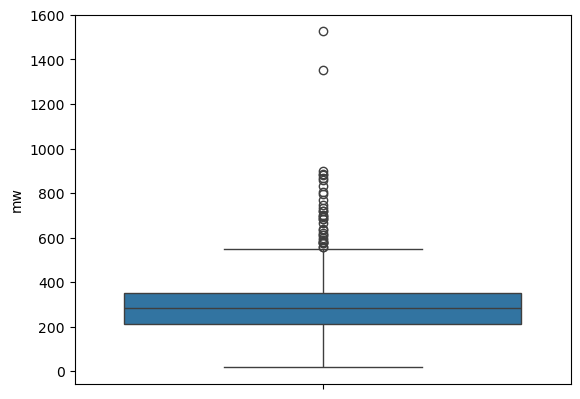

In [143]:
pesticides_mw = mw_calc(pesticides, 'SMILES')
# visualize and remove based on https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/
import seaborn as sns
print(sns.boxplot(pesticides_mw['mw']))

In [151]:
# calculate threshold
from scipy.stats import iqr
from scipy.ndimage import median
iqr_val = iqr(pesticides_mw['mw'])
median_val = median(pesticides_mw['mw'])
q3_val = np.percentile(pesticides_mw['mw'], 75)
upper_outlier = q3_val+1.5*iqr_val
print(f'iqr: {iqr_val}')
print(f'median: {median_val}')
print(f'Q3 val: {q3_val}')
print(f'upper limit for 1.5 IQR above Q3: {upper_outlier}')

iqr: 137.22000000000008
median: 284.3615
Q3 val: 350.4745000000001
upper limit for 1.5 IQR above Q3: 556.3045000000002


In [158]:
print(pesticides_mw.shape)
pesticides_no_outliers = pesticides_mw[pesticides_mw['mw'] <= upper_outlier]
print(pesticides_no_outliers.shape)

(1850, 5)
(1816, 5)


Axes(0.125,0.11;0.775x0.77)


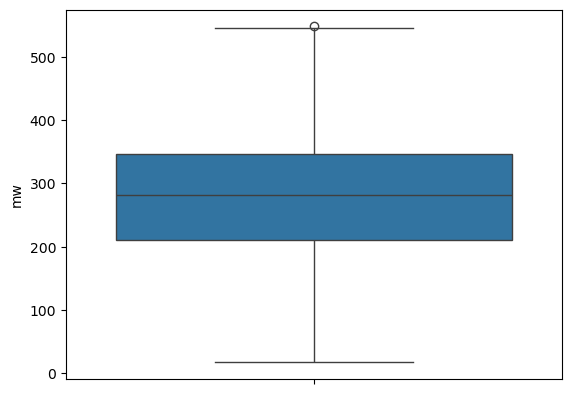

In [159]:
print(sns.boxplot(pesticides_no_outliers['mw']))

In [160]:
pesticides_no_outliers = pesticides_no_outliers.drop(columns=['mw'])
pesticides_no_outliers.head(1)

,PREFERRED NAME,CASRN,use,SMILES
14,"1-bromo-3-chloro-5,5-dimethyl hydantoin",16079-88-2,"Fungicide,Herbicide,Microbiocide",CC1(C)N(Br)C(=O)N(Cl)C1=O


# Data Augmentation

In [274]:
#insecticides.head(10)

In [67]:
# idea 1
def aliphatic_string(df, col):
    '''
    For each carbon string of 3 or more, create a new molecule with one less carbon and one with one more
    '''
    df_temp = df.copy().reset_index()

    augmented_addC = []
    #augmented_minusC = []
    
    for index, row in df_temp.iterrows():
        smi = df_temp[col][index]
        if 'CCC' in smi:
            original = df_temp.iloc[index,:] 
            
            # get the first CCC.. string
            # make a longer version
            plus_C = smi.replace('CCC', 'CCCC', 1) # only do one replacement
            #print(plus_C) # for testing
            plus_C_row = original
            #plus_C_row[0] = 'aug_addC'
            #plus_C_row[1] = 'aug_addC'
            #plus_C_row[2] = 'aug_addC'
            #plus_C_row[3] = 'aug_addC'
            #plus_C_row[5] = 'aug_addC'
            plus_C_row[8] = plus_C
            augmented_addC.append(plus_C_row)
            
            #print(smi) # for testing
            # make a shorter version
            #minus_C = smi.replace('CCC', 'CC', 1)
            #print(minus_C) # for testing
            #minus_C_row = original
            #minus_C_row[0] = 'aug_minusC'
            #minus_C_row[1] = 'aug_minusC'
            #minus_C_row[2] = 'aug_minusC'
            #minus_C_row[3] = 'aug_minusC'
            #minus_C_row[5] = 'aug_minusC'
            #minus_C_row[8] = minus_C
            #augmented_minusC.append(minus_C_row)
            
    addC = pd.DataFrame(augmented_addC)
    #minusC = pd.DataFrame(augmented_minusC)

    #out_df = pd.concat([addC, minusC], axis=0, ignore_index=True, verify_integrity=True)
    #print(out_df.shape[0])
    out_df = pd.concat([df_temp, addC], ignore_index=True)
    
    return out_df

In [69]:
print(pesticides.shape)
print(insecticides.shape)
aug_insecticides = aliphatic_string(insecticides, 'SMILES')
aug_pesticides = aliphatic_string(pesticides, 'SMILES')
print(aug_pesticides.shape)
print(aug_insecticides.shape)

(1673, 4)
(580, 4)


C:\Users\tobia\AppData\Local\Temp\ipykernel_24524\3866211349.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plus_C_row[8] = plus_C


IndexError: index 8 is out of bounds for axis 0 with size 5

In [277]:
aug_insecticides.head(2)

,index,name,pri,casrn,class,mw,use,smiles,no_salt
0,35,1-Chloro-2-nitrobenzene,46,88-73-3,Unclassified,157.56,Insecticide,[O-][N+](=O)c1ccccc1Cl,[O-][N+](=O)c1ccccc1Cl
1,38,1-Chloro-3-nitrobenzene,49,121-73-3,Unclassified,157.56,Insecticide,[O-][N+](=O)c1cccc(Cl)c1,[O-][N+](=O)c1cccc(Cl)c1


# Predict Log P

In [161]:
from rdkit.Chem.QED import properties

In [162]:
def alogp(df, col):
    '''
    calculates logP using QED ALogP
    https://www.rdkit.org/docs/source/rdkit.Chem.QED.html
    ''' 
    logp_storage = []

    smiles = df[col]
    
    for smi in smiles:
        mol = Chem.MolFromSmiles(smi)
        properties = rdkit.Chem.QED.properties(mol)
        logp = properties[1]
        logp_storage.append(logp)

    df['alogp'] = logp_storage

    return df

In [164]:
pesticides_logp = alogp(pesticides_no_outliers, 'SMILES')

In [165]:
print(pesticides_logp.shape)

(1816, 5)


In [167]:
pesticides_logp.tail()

,PREFERRED NAME,CASRN,use,SMILES,alogp
79,Atractylodin,55290-63-6,Insecticide,C\C=C\C#CC#C\C=C\C1=CC=CO1,2.8757
80,Deoxyisocalyciphylline B,619326-74-8,Insecticide,[H][C@]12CCC=C1[C@]1([H])N3C[C@@H](C)[C@@]4([H...,3.9274
81,Ermanin,20869-95-8,Insecticide,COC1=CC=C(C=C1)C1=C(OC)C(=O)C2=C(O)C=C(O)C=C2O1,2.8884
82,"1(3H)-Isobenzofuranone, 3-butylidene-",551-08-6,Insecticide,CCCC=C1OC(=O)C2=C1C=CC=C2,2.9980
83,"5-[2-(Furan-3-yl)ethyl]-5,6,8a-trimethyl-3,4,4...",1782-65-6,Insecticide,[H][C@@]1(C)CC[C@@]2(C)C(=CCC[C@]2([H])[C@]1(C...,5.0757


In [2]:
# save intermediate output
pesticides_logp.to_csv("pesticides_logp.csv")

NameError: name 'pesticides_logp' is not defined

# LogP Outlier Removal

In [2]:
pesticides_logp = pd.read_csv('pesticides_logp.csv')

Axes(0.125,0.11;0.775x0.77)


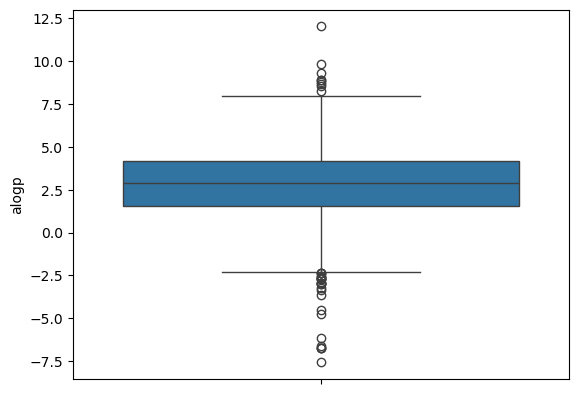

In [3]:
import seaborn as sns
print(sns.boxplot(pesticides_logp['alogp']))

In [4]:
# calculate threshold
from scipy.stats import iqr
from scipy.ndimage import median
iqr_val = iqr(pesticides_logp['alogp'])
median_val = median(pesticides_logp['alogp'])
q3_val = np.percentile(pesticides_logp['alogp'], 75)
q1_val = np.percentile(pesticides_logp['alogp'], 25)
upper_outlier = q3_val+1.5*iqr_val
lower_outlier = q1_val-1.5*iqr_val
print(f'iqr: {iqr_val}')
print(f'median: {median_val}')
print(f'Q3 val: {q3_val}')
print(f'Q1 val: {q1_val}')
print(f'upper limit for 1.5 IQR above Q3: {upper_outlier}')
print(f'lower limit for 1.5 IQR below Q1: {lower_outlier}')

iqr: 2.6209500000000037
median: 2.8934200000000003
Q3 val: 4.1898000000000035
Q1 val: 1.5688499999999999
upper limit for 1.5 IQR above Q3: 8.12122500000001
lower limit for 1.5 IQR below Q1: -2.3625750000000054


In [5]:
print(pesticides_logp.shape)
pesticides_logp = pesticides_logp[pesticides_logp['alogp'] <= upper_outlier]
pesticides_logp = pesticides_logp[pesticides_logp['alogp'] >= lower_outlier]
print(pesticides_logp.shape)

(1816, 6)
(1781, 6)


# SMILES to Graphs  via Torch Geometric

Code from https://pytorch-geometric.readthedocs.io/en/2.4.0/_modules/torch_geometric/utils/smiles.html
This was found to be invertible, which is important for computing evaluation metrics

In [6]:
# import
pesticides_logp = pesticides_logp.drop(columns=['Unnamed: 0'])
print(pesticides_logp.shape)
pesticides_logp.head(1)

(1781, 5)


,PREFERRED NAME,CASRN,use,SMILES,alogp
0,"1-bromo-3-chloro-5,5-dimethyl hydantoin",16079-88-2,"Fungicide,Herbicide,Microbiocide",CC1(C)N(Br)C(=O)N(Cl)C1=O,1.4929


In [7]:
# first separate insecticides
print(pesticides_logp.shape)
insecticides_logp = pesticides_logp[pesticides_logp['use'].str.contains('Insecticide')]
print(insecticides_logp.shape)

(1781, 5)
(625, 5)


In [11]:
!pip install torch torch_geometric

  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
Using cached torch_geometric-2.6.1-py3-none-any.whl (1.1 MB)


In [12]:
from typing import Any
import torch
import torch_geometric
from rdkit import Chem, RDLogger
from torch_geometric.data import Data

In [19]:
# from https://pytorch-geometric.readthedocs.io/en/2.4.0/_modules/torch_geometric/utils/smiles.html
# revised per comments
x_map = {
    'atomic_num':
    list(range(0, 119)),
    'degree':
    list(range(0, 11)),
    'formal_charge':
    list(range(-5, 7))
}

# only specify bond type
e_map = {
    'bond_type': [
        'UNSPECIFIED',
        'SINGLE',
        'DOUBLE',
        'TRIPLE',
        'QUADRUPLE',
        'QUINTUPLE',
        'HEXTUPLE',
        'ONEANDAHALF',
        'TWOANDAHALF',
        'THREEANDAHALF',
        'FOURANDAHALF',
        'FIVEANDAHALF',
        'AROMATIC',
        'HYDROGEN',
        'THREECENTER',
    ]
}

def from_smiles(smiles: str) -> 'torch_geometric.data.Data':
    r"""Converts a SMILES string to a :class:`torch_geometric.data.Data`
    instance.

    Args:
        smiles (str): The SMILES string.
    """
    RDLogger.DisableLog('rdApp.*')
    
    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
        mol = Chem.MolFromSmiles('')

    xs = []
    for atom in mol.GetAtoms():
        x = []
        x.append(x_map['atomic_num'].index(atom.GetAtomicNum()))
        x.append(x_map['degree'].index(atom.GetTotalDegree()))
        x.append(x_map['formal_charge'].index(atom.GetFormalCharge()))
        xs.append(x)

    x = torch.tensor(xs, dtype=torch.long).view(-1, 3)

    edge_indices, edge_attrs = [], []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        e = []
        e.append(e_map['bond_type'].index(str(bond.GetBondType())))

        edge_indices += [[i, j], [j, i]] # this creates the adjacency matrix
        edge_attrs += [e, e] # this creates the edge attributes matrix

    edge_index = torch.tensor(edge_indices)
    edge_index = edge_index.t().to(torch.long).view(2, -1)
    edge_attr = torch.tensor(edge_attrs, dtype=torch.long).view(-1, 1)

    if edge_index.numel() > 0:  # Sort indices.
        perm = (edge_index[0] * x.size(0) + edge_index[1]).argsort()
        edge_index, edge_attr = edge_index[:, perm], edge_attr[perm]

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, smiles=smiles)



def to_smiles(data: 'torch_geometric.data.Data') -> Any:
    """Converts a :class:`torch_geometric.data.Data` instance to a SMILES
    string.

    Args:
        data (torch_geometric.data.Data): The molecular graph.
    """
    from rdkit import Chem

    mol = Chem.RWMol()

    for i in range(data.num_nodes):
        atom = Chem.Atom(data.x[i, 0].item())
        atom.SetFormalCharge(x_map['formal_charge'][data.x[i, 2].item()])
        mol.AddAtom(atom)

    edges = [tuple(i) for i in data.edge_index.t().tolist()]
    visited = set()

    for i in range(len(edges)):
        src, dst = edges[i]
        if tuple(sorted(edges[i])) in visited:
            continue

        bond_type = Chem.BondType.values[data.edge_attr[i, 0].item()]
        mol.AddBond(src, dst, bond_type)

        visited.add(tuple(sorted(edges[i])))

    mol = mol.GetMol()

    Chem.SanitizeMol(mol)
    Chem.AssignStereochemistry(mol)

    return Chem.MolToSmiles(mol, isomericSmiles=True)

In [92]:
# define function to create data
# based on adapted code from https://www.blopig.com/blog/2022/02/how-to-turn-a-smiles-string-into-a-molecular-graph-for-pytorch-geometric/
def create_py_geom_dataset(x_smiles, y):
    '''
    x_smiles = column with input smiles
    y = column with relevant property value
    '''
    data_list = []
    
    for (smiles, y_val) in zip(x_smiles, y):

        initial_data = from_smiles(smiles)

        X = initial_data.x.detach()
        E = initial_data.edge_index.detach()
        EF = initial_data.edge_attr.detach()
        y_tensor = torch.tensor(y_val, dtype = torch.float)
        
        data_list.append(Data(x = X, edge_index = E, edge_attr = EF, y = y_tensor))
    return data_list

def create_smiles_data(py_geom_df):
    '''
    Creates a dataset with smiles and y values
    Inputs:
    py_geom_df = input dataset that is a pytorch geometric with a y tensor
    '''
    data_list = []
    idx = range(len(py_geom_df))
    for i in idx:

        smiles = to_smiles(py_geom_df[i])
        y = py_geom_df[i].y.detach().tonumpy()
        
        data_list.append(smiles)
        data_list.append(y)
    df_out = pd.DataFrame(data_list)
    return data_list

In [90]:
print(pesticides_logp.shape)
print(insecticides_logp.shape)
pesticides_graph_v2 = create_py_geom_dataset(pesticides_logp['SMILES'], pesticides_logp['alogp'])
insecticides_graph_v2 = create_py_geom_dataset(insecticides_logp['SMILES'], insecticides_logp['alogp'])
print(len(pesticides_graph_v2))
print(len(insecticides_graph_v2))

(1781, 5)
(625, 5)
1781
625


In [91]:
torch.save(pesticides_graph_v2, "pesticides_graphs_small.pt")
torch.save(insecticides_graph_v2, "insecticides_graphs_small.pt")

# SMILES to Graphs
from https://www.blopig.com/blog/2022/02/how-to-turn-a-smiles-string-into-a-molecular-graph-for-pytorch-geometric/

In [2]:
# RDkit
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
# Pytorch and Pytorch Geometric
import torch
from torch_geometric.data import Data
from torch.utils.data import DataLoader

### Atom featurization

In [285]:
def one_hot_encoding(x, permitted_list):
    """
    Maps input elements x which are not in the permitted list to the last element
    of the permitted list.
    """
    if x not in permitted_list:
        x = permitted_list[-1]
    binary_encoding = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]
    return binary_encoding

In [286]:
def get_atom_features(atom, 
                      use_chirality = True, 
                      hydrogens_implicit = True):
    """
    Takes an RDKit atom object as input and gives a 1d-numpy array of atom features as output.
    """
    # define list of permitted atoms
    
    permitted_list_of_atoms =  ['C','N','O','S','F','Si','P','Cl','Br','Mg','Na','Ca','Fe','As','Al','I', 'B','V','K','Tl','Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn', 'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr','Pt','Hg','Pb','Unknown']
    
    if hydrogens_implicit == False:
        permitted_list_of_atoms = ['H'] + permitted_list_of_atoms
    
    # compute atom features
    
    atom_type_enc = one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)
    
    n_heavy_neighbors_enc = one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])
    
    formal_charge_enc = one_hot_encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, "Extreme"])
    
    hybridisation_type_enc = one_hot_encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])
    
    is_in_a_ring_enc = [int(atom.IsInRing())]
    
    is_aromatic_enc = [int(atom.GetIsAromatic())]
    
    atomic_mass_scaled = [float((atom.GetMass() - 10.812)/116.092)]
    
    vdw_radius_scaled = [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5)/0.6)]
    
    covalent_radius_scaled = [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64)/0.76)]
    atom_feature_vector = atom_type_enc + n_heavy_neighbors_enc + formal_charge_enc + hybridisation_type_enc + is_in_a_ring_enc + is_aromatic_enc + atomic_mass_scaled + vdw_radius_scaled + covalent_radius_scaled
                                    
    if use_chirality == True:
        chirality_type_enc = one_hot_encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
        atom_feature_vector += chirality_type_enc
    
    if hydrogens_implicit == True:
        n_hydrogens_enc = one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
        atom_feature_vector += n_hydrogens_enc
    return np.array(atom_feature_vector)

### Bond featurization

In [287]:
def get_bond_features(bond, 
                      use_stereochemistry = True):
    """
    Takes an RDKit bond object as input and gives a 1d-numpy array of bond features as output.
    """
    permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]
    bond_type_enc = one_hot_encoding(bond.GetBondType(), permitted_list_of_bond_types)
    
    bond_is_conj_enc = [int(bond.GetIsConjugated())]
    
    bond_is_in_ring_enc = [int(bond.IsInRing())]
    
    bond_feature_vector = bond_type_enc + bond_is_conj_enc + bond_is_in_ring_enc
    
    if use_stereochemistry == True:
        stereo_type_enc = one_hot_encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
        bond_feature_vector += stereo_type_enc
    return np.array(bond_feature_vector)

### Function to integrate and create dataset

In [288]:
def create_pytorch_geometric_graph_data_list_from_smiles_and_labels(x_smiles, y):
    """
    Inputs:
    
    x_smiles = [smiles_1, smiles_2, ....] ... a list of SMILES strings
    y = [y_1, y_2, ...] ... a list of numerial labels for the SMILES strings (such as associated pKi values)
    
    Outputs:
    
    data_list = [G_1, G_2, ...] ... a list of torch_geometric.data.Data objects which represent labeled molecular graphs that can readily be used for machine learning
    
    """
    
    data_list = []
    
    for (smiles, y_val) in zip(x_smiles, y):
        
        # convert SMILES to RDKit mol object
        mol = Chem.MolFromSmiles(smiles)
        # get feature dimensions
        n_nodes = mol.GetNumAtoms()
        n_edges = 2*mol.GetNumBonds()
        unrelated_smiles = "O=O"
        unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
        n_node_features = len(get_atom_features(unrelated_mol.GetAtomWithIdx(0)))
        n_edge_features = len(get_bond_features(unrelated_mol.GetBondBetweenAtoms(0,1)))
        # construct node feature matrix X of shape (n_nodes, n_node_features)
        X = np.zeros((n_nodes, n_node_features))
        for atom in mol.GetAtoms():
            X[atom.GetIdx(), :] = get_atom_features(atom)
            
        X = torch.tensor(X, dtype = torch.float)
        
        # construct edge index array E of shape (2, n_edges)
        (rows, cols) = np.nonzero(GetAdjacencyMatrix(mol))
        torch_rows = torch.from_numpy(rows.astype(np.int64)).to(torch.long)
        torch_cols = torch.from_numpy(cols.astype(np.int64)).to(torch.long)
        E = torch.stack([torch_rows, torch_cols], dim = 0)
        
        # construct edge feature array EF of shape (n_edges, n_edge_features)
        EF = np.zeros((n_edges, n_edge_features))
        
        for (k, (i,j)) in enumerate(zip(rows, cols)):
            
            EF[k] = get_bond_features(mol.GetBondBetweenAtoms(int(i),int(j)))
        
        EF = torch.tensor(EF, dtype = torch.float)
        
        # construct label tensor
        y_tensor = torch.tensor(np.array([y_val]), dtype = torch.float)
        
        # construct Pytorch Geometric data object and append to data list
        data_list.append(Data(x = X, edge_index = E, edge_attr = EF, y = y_tensor))
    return data_list

### Create datasets

In [289]:
pesticides_graph = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(pesticides_logp['no_salt'], pesticides_logp['alogp'])
insecticides_graph = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(insecticides_logp['no_salt'], insecticides_logp['alogp'])

In [290]:
torch.save(pesticides_graph, "pesticides_graphs.pt")
torch.save(insecticides_graph, "insecticides_graphs.pt")